# IS 470 Assignment 1: Predicting Customer Churn Using Decision Trees

This assignment will help you understand how machine learning models, specifically decision
trees, are used to solve real-world business problems such as predicting customer churn. You’ll
explore a dataset, build classification models, and evaluate their performance. This foundational
project builds your skills for future assignments and gives you hands-on experience relevant to
careers in data science, analytics, and business intelligence.

In [1]:
# Mounting Google rive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from scipy.stats import pointbiserialr


In [3]:
# Read data
customer_churn = pd.read_csv('/content/drive/MyDrive/IS470_data/CutomerChurnData.csv')
customer_churn

,cust_id,region,tenure,age,marital,address,income,ed,employ,retire,...,internet,callid,callwait,forward,confer,ebill,loglong,lninc,custcat,churn
0,C00124,R2,13,44,Y,9,64,E4,5,N,...,N,N,N,Y,N,N,1.308,4.159,C1,Y
1,C00125,R3,68,52,Y,24,116,E1,29,N,...,N,Y,Y,N,Y,N,2.899,4.754,C3,N
2,C00126,R2,23,30,Y,9,30,E1,2,N,...,N,Y,N,Y,Y,N,1.841,3.401,C3,N
3,C00127,R3,45,22,Y,2,19,E2,4,N,...,Y,N,Y,N,N,Y,2.389,2.944,C2,Y
4,C00128,R3,45,59,Y,7,166,E4,31,N,...,N,Y,Y,Y,Y,N,2.277,5.112,C3,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C01119,R1,50,43,N,6,27,E3,4,N,...,N,Y,Y,Y,Y,N,2.708,3.296,C3,N
996,C01120,R1,34,52,Y,2,106,E2,19,N,...,Y,Y,N,Y,Y,N,1.599,4.663,C3,N
997,C01121,R1,15,46,Y,17,63,E5,1,N,...,Y,Y,N,Y,Y,Y,1.308,4.143,C4,Y
998,C01122,R1,7,34,N,2,22,E5,5,N,...,N,N,N,N,N,N,1.537,3.091,C1,N


## Business Understanding:<br/>
**Customer Churn:** This is a number which represents the percentage of customers who stop using your product or service over a given time.<br/>
**Customer Churn in the Telecommunications Industry:** This would be what percentage of customers stop using your service during any given time<br/><br/>
For the purpose of analysis, we can form this into a binary classification problem by defining two unique states:

*   Churned Customers
*   Retained Customers


In [4]:
customer_churn.keys()

Index(['cust_id', 'region', 'tenure', 'age', 'marital', 'address', 'income',
       'ed', 'employ', 'retire', 'gender', 'reside', 'tollfree', 'equip',
       'callcard', 'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon',
       'wiremon', 'longten', 'tollten', 'equipten', 'cardten', 'wireten',
       'multline', 'voice', 'pager', 'internet', 'callid', 'callwait',
       'forward', 'confer', 'ebill', 'loglong', 'lninc', 'custcat', 'churn'],
      dtype='object')

## Data Understanding
### Definitions
**cust_id:** This is just a unique identifier<br/>
**region:** Area of the country<br/>
**tenure:** The amount of months that a customer has been a customer<br/>
**age:** The age of the customer in years<br/>
**marital:** This appears to be the marital status? Y or N<br/>
**address:** Number of years at current address<br/>
**income:** Annual Income (in thousands of dollars)<br/>
**ed:** Educational level<br/>
**employ:** Number of years employed<br/>
**retire:** Retirement Status<br/>
**gender:** Gender<br/>
**reside:** Number of people in household<br/>
**tollfree:** Whether customer has toll-free service<br/>
**equip:** Whether customer has equipment protection<br/>
**callcard:** Uses calling card service<br/>
**wireless:** Has wireless service<br/>
**longmon:** Long-distance minutes used in last month<br/>
**tollmon:** Toll-free minutes used in last month<br/>
**equipmon:** Equipment charges this month<br/>
**cardmon:** Calling card charges this month<br/>
**wiremon:** Wireless charges this month<br/>
**longten:** Cumulative long-distance usage over tenure<br/>
**tollten:** Cumulative toll-free usage over tenure<br/>
**equipten:** Cumulative equipment charges over tenure<br/>
**cardten:** Cumulative calling card charges over tenure<br/>
**wireten:** Cumulative wireless charges over tenure<br/>
**multline:** Has multiple phone lines<br/>
**voice:** Has voice mail service<br/>
**pager:** Has pager service<br/>
**internet:** Has internet service<br/>
**callid:** Has caller ID<br/>
**callwait:** Has call waiting<br/>
**forward:** Has call forwarding<br/>
**confer:** Has conference calling feature<br/>
**ebill:** Uses electronic billing<br/>
**loglong:** Log-transformed long distance usage<br/>
**lninc:** Log-transformed Income<br/>
**custcat:** Customer cateogory<br/>
**churn:** Whether customer churned



In order to determine how each variable relates to the problem at hand (which is whether or not a customer churned). I am creating the following set of functions.<br/>

*   preprocess_churn_data : This function is needed because the data is not in an operational state. For example things like money might be represented as $4.99 and the system doesn't know how to handle that. so this function cleans that up
*   analyse_churn_correlations : this function is what actually does the analysis. depending on whether the field is numeric or categorical it uses one or another function to determine the correlation with teh control variable (churn) it then outputs the results in order.
<br/>Note, both of these functions where originally created by ChatGPT, however I have studied them and understand what they do.



In [5]:
def preprocess_churn_data(df):
    df_clean = df.copy()

    # Step 1: Convert churn column to binary
    if 'churn' in df_clean.columns:
        df_clean['churn'] = df_clean['churn'].map({'Y': 1, 'N': 0})

    # Step 2: Convert all 'Y'/'N' columns to 1/0
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object' and set(df_clean[col].dropna().unique()) <= {'Y', 'N'}:
            df_clean[col] = df_clean[col].map({'Y': 1, 'N': 0})

    # Step 3: Try converting object columns to numeric where possible
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # Remove symbols and try to convert
            df_clean[col] = df_clean[col].str.replace(r'[\$,K]', '', regex=True)
            try:
                df_clean[col] = pd.to_numeric(df_clean[col])
            except:
                pass  # Leave as is if it can't be converted

    return df_clean


In [6]:
def analyze_churn_correlations(df, target_col='churn', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")

    # Prepare variables
    X = df.drop(columns=[target_col] + exclude_cols)
    y = df[target_col]

    results = []

    for col in X.columns:
        try:
            # Skip all-null columns
            if X[col].isnull().all():
                continue

            # If it's numeric and can be converted
            if pd.api.types.is_numeric_dtype(X[col]):
                corr, p_val = pointbiserialr(X[col].fillna(0), y)
                results.append({
                    'feature': col,
                    'type': 'numeric',
                    'metric': 'point_biserial_corr',
                    'score': abs(corr),
                    'p_value': p_val
                })
            else:
                # Convert to categorical explicitly
                mi = mutual_info_classif(X[[col]].fillna('NA').astype(str), y, discrete_features=True)
                results.append({
                    'feature': col,
                    'type': 'categorical',
                    'metric': 'mutual_info',
                    'score': mi[0],
                    'p_value': None
                })

        except Exception as e:
            print(f"Skipping column {col}: {e}")

    results_df = pd.DataFrame(results)

    if not results_df.empty and 'score' in results_df.columns:
        return results_df.sort_values(by='score', ascending=False).reset_index(drop=True)
    else:
        raise ValueError("No valid features found. Please check your data types and column names.")


Now we actually use this function to determine the relationships

In [7]:

# Step 1: Preprocess your data
df_clean = preprocess_churn_data(customer_churn)

# Step 2: Run correlation analysis
exclude_cols = ['cust_id']  # Add any other irrelevant ID columns
result = analyze_churn_correlations(df_clean, target_col='churn', exclude_cols=exclude_cols)

# Step 3: View the results
print(result)




Skipping column region: could not convert string to float: 'R2'
Skipping column ed: could not convert string to float: 'E4'
Skipping column custcat: could not convert string to float: 'C1'
     feature     type               metric     score       p_value
0     tenure  numeric  point_biserial_corr  0.373287  2.031174e-34
1    loglong  numeric  point_biserial_corr  0.323931  7.319137e-26
2   internet  numeric  point_biserial_corr  0.310136  9.784239e-24
3      equip  numeric  point_biserial_corr  0.267653  7.246184e-18
4     employ  numeric  point_biserial_corr  0.263677  2.285789e-17
5    longten  numeric  point_biserial_corr  0.256774  1.604942e-16
6    longmon  numeric  point_biserial_corr  0.251933  6.083048e-16
7   callcard  numeric  point_biserial_corr  0.241241  1.044913e-14
8    cardten  numeric  point_biserial_corr  0.234727  5.531369e-14
9        age  numeric  point_biserial_corr  0.229835  1.871681e-13
10     ebill  numeric  point_biserial_corr  0.229782  1.896224e-13
11  equ

Note, the above list is in order of importance, with the score value being how close the variable tracks with the churn parameter.  This is how we are doing the following charts and graphs

Note, for some reason the fields: region, ed, and custcat were all not processible so I would like to take a quick look at those first to see if there is anything we can learn about them

In [8]:
customer_churn[['region','ed','custcat']].describe()

,region,ed,custcat
count,1000,1000,1000
unique,3,5,4
top,R3,E2,C3
freq,346,290,290


Nothing in particular odd, lets take a closer look

In [9]:
customer_churn['region'].value_counts()

,count
region,
R3,346
R2,338
R1,316


In [10]:
customer_churn['ed'].value_counts()

,count
ed,
E2,290
E3,220
E1,218
E4,216
E5,56


In [11]:
customer_churn['custcat'].value_counts()

,count
custcat,
C3,290
C1,254
C4,240
C2,216


Again, not seeing anything in particular odd here, although I do wonder what exactly custcat is for? (my guess is this is a numeric index referencing some other data set).  Next we will start looking at some of the more important values (according to the results of our previous algorithmic inspection of the values)

In [12]:
# Lets get some summary stats for the most important variables
customer_churn[['tenure', 'loglong']].describe()

,tenure,loglong
count,1000.000000,1000.000000
mean,35.242000,2.149468
std,21.295937,0.716255
min,1.000000,0.049000
25%,16.000000,1.639000
50%,34.500000,2.140000
75%,53.000000,2.629000
max,72.000000,4.605000


Yea, i'm not really sure what this shows us other than the basic shape of the data, that being tenure has a mean around 35, and laglong 2.14. Lets try another...

Text(0.5, 1.0, 'Boxplot age')

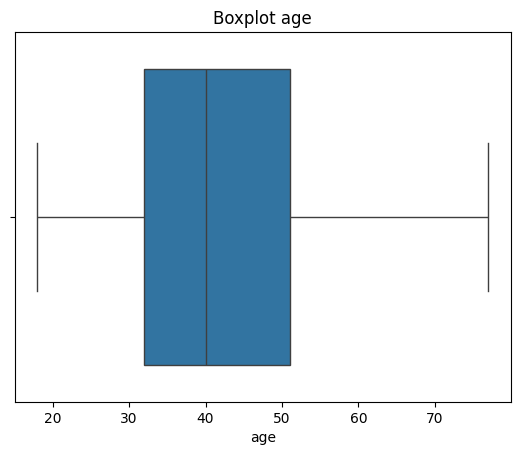

In [13]:
# Boxplot of age (What age is associated with churning?)
snsplot = sns.boxplot(x='age', data = customer_churn)
snsplot.set_title('Boxplot age')


Ok, this one might be insightful.  Basically it says that about half the people who churn are between the ages of 32 and 51.  Not sure how interesting that is, but perhaps it says we shouldn't focus on older people (probably becuase they don't change very often so are less likely to churn?)

(0.0, 200.0)

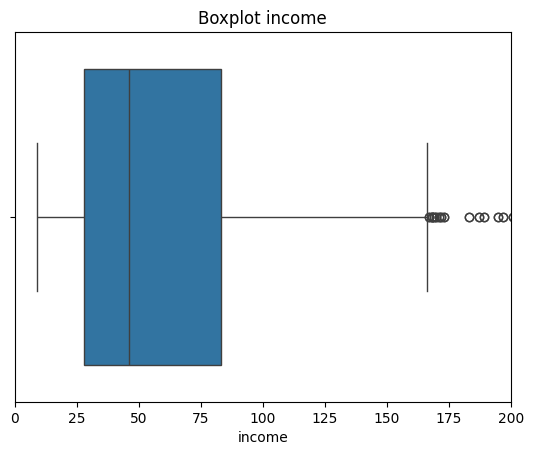

In [14]:
# Boxplot of income
snsplot = sns.boxplot(x='income', data = customer_churn)
snsplot.set_title('Boxplot income')
snsplot.set_xlim(0, 200)

This one is also interesting, basically people who make between 26k and 81k are the most likely to churn (probably those who make more are not so concerned about their phone bill)

Text(0.5, 1.0, 'Histogram age')

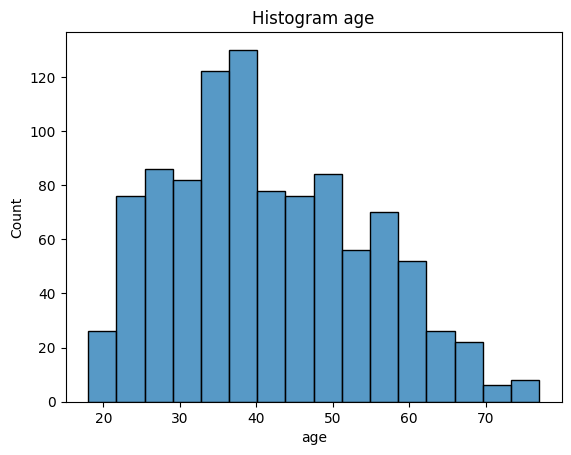

In [15]:
snsplot = sns.histplot(x='age', data = customer_churn)
snsplot.set_title('Histogram age')

Nothing odd here really (what would be odd is having multiple peaks)

Text(0.5, 1.0, 'Scatterplot tenure vs years at current address')

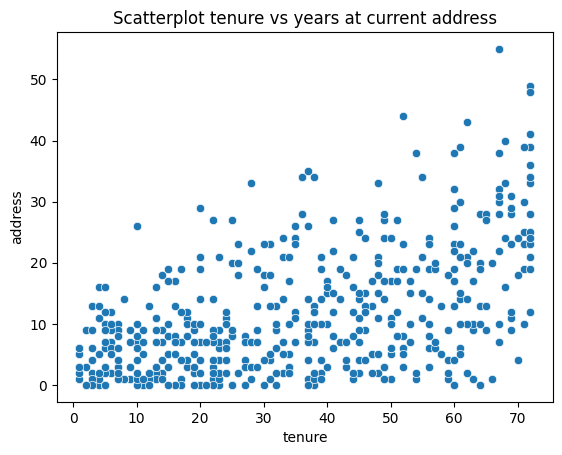

In [16]:
snsplot = sns.scatterplot(x='tenure', y='address', data = customer_churn)
snsplot.set_title('Scatterplot tenure vs years at current address')

ok, it took me several tries to get some numbers that make a graph that actually makes sense.  This particular one seems fairly obvious.  Basically what it is saying is the longer you stay at one address, the longer your tenure is.  While this is true, it also seems to be kind of useless in my opinion.

In [17]:
sns.pairplot(data = customer_churn)

Output hidden; open in https://colab.research.google.com to view.

Ok, I did this one simply because I wanted to see all the charts.  But after looking at it, I can kinda see why it's done.  By creating this set of charts you can very quickly identify annomolies where you might want to investigate further.

After further investigation into all the various charts shown above, I was unable to come to any conclusions.  The problem is there's just too much data and it is hard to see what is important.  For example, whever i saw a curve or something that looks formulaic, I would notice that the values were directly tied to each other like wiremon vs wireten.  I don't think this tells me anything other than what we already know.

What is our target variable?  This would be churn:

In [18]:
customer_churn['churn'].value_counts()

,count
churn,
N,742
Y,258


Based on this, you could say this variable is binary. and also more likely be N (which means the customer did not churn)

To answer the question "Do I think other existing variables can help build a meaningful and predictive classification model for the target variable"  The answer would be, sure, we can use probably all of the variables, but whether the output is meaningful or not is debatable.  For example. lets say we determine that people who have not had their jobs very long are likely to churn.  So what? what do we do with that information?

## ...A Second look at the data

After thinking about this for a couple days, I came to the thought of. what exactly is the purpose or end goal of this data analysis.  Like, what are the theoretical actions a company might take based on this data.  The first thing that comes to mind is advertising.  Advertising is expensive and it is important that the correct groups be targeted or this money will be wasted.  In advertising, I suspect the major deciders of how an ad is created would be major demographic segments.  Are we targeting old people or young people?  Men or women? etc...  So, the next couple of data analysis tasks are with that in mind.  Who is more likely to churn?  This is possibly who we should be targeting our ads too.

Text(0.5, 1.0, 'Boxplot age')

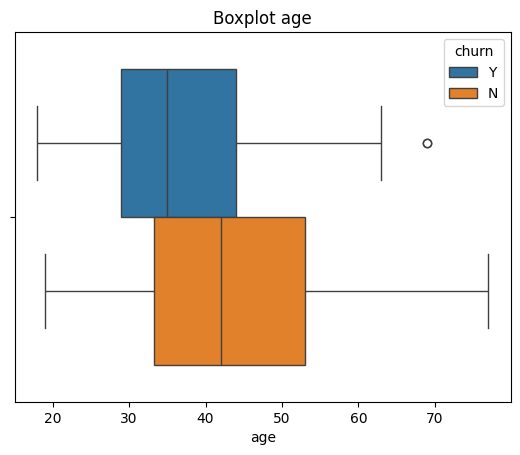

In [19]:
snsplot = sns.boxplot(x='age', data = customer_churn, hue='churn')
snsplot.set_title('Boxplot age')

Ok, this re-confirms my guess that younger people tend to churn more. now lets look at gender

In [31]:
customer_churn['gender'].value_counts()

,count
gender,
Y,502
N,498


Text(0.5, 1.0, 'Boxplot gender')

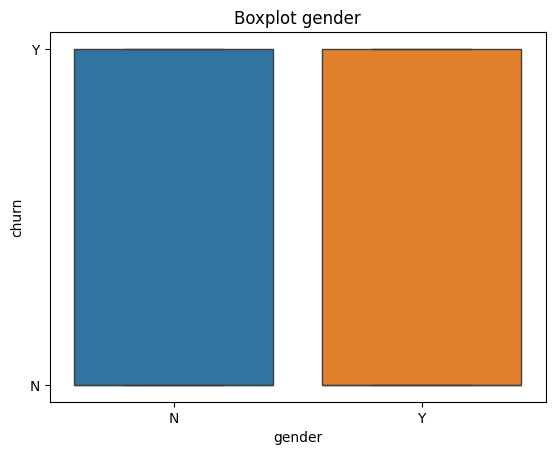

In [30]:
snsplot = sns.boxplot(x='gender', y='churn', data = customer_churn, hue='gender')
snsplot.set_title('Boxplot gender')

Unfortunately, I had to do both of the above charts to figure out what is going on and i still don't really know.  I don't understand why gender is Y/N (when you would expect it to be M/F) so that makes me question the data itself.  Assuming that either of these is male or female however you can see that there isn't much difference in the graphs which again makes me wonder if we even understand the data we are looking at.  I personally am highly skeptical that it is an almost perfect match between men and women who churn just based on my understanding of technology and 20 years in the industry (which has more men than woman by a 10 to 1 margin)<br/><br/>Anyhow, we can summarise a bit from this last round of analysis that it would probably be wise to target younger people.  Further analysis along these lines might help us narrow down the target even more.

## Data Preparation

In [32]:
# Check for null values
customer_churn.isnull().sum()

,0
cust_id,0
region,0
tenure,0
age,0
marital,0
address,0
income,0
ed,0
employ,0
retire,0


In [33]:
# Drop the useless cust_id index
customer_churn = customer_churn.drop(columns=['cust_id'])

In [34]:
# Examine variable types
customer_churn.dtypes

,0
region,object
tenure,int64
age,int64
marital,object
address,int64
income,int64
ed,object
employ,int64
retire,object
gender,object


In [35]:
# change categorical variables to 'category'
customer_churn['region'] = customer_churn['region'].astype('category')
customer_churn['marital'] = customer_churn['marital'].astype('category')
customer_churn['ed'] = customer_churn['ed'].astype('category')
customer_churn['retire'] = customer_churn['retire'].astype('category')
customer_churn['gender'] = customer_churn['gender'].astype('category')
customer_churn['tollfree'] = customer_churn['tollfree'].astype('category')
customer_churn['equip'] = customer_churn['equip'].astype('category')
customer_churn['callcard'] = customer_churn['callcard'].astype('category')
customer_churn['wireless'] = customer_churn['wireless'].astype('category')
customer_churn['multline'] = customer_churn['multline'].astype('category')
customer_churn['voice'] = customer_churn['voice'].astype('category')
customer_churn['pager'] = customer_churn['pager'].astype('category')
customer_churn['internet'] = customer_churn['internet'].astype('category')
customer_churn['callid'] = customer_churn['callid'].astype('category')
customer_churn['callwait'] = customer_churn['callwait'].astype('category')
customer_churn['forward'] = customer_churn['forward'].astype('category')
customer_churn['confer'] = customer_churn['confer'].astype('category')
customer_churn['ebill'] = customer_churn['ebill'].astype('category')
customer_churn['custcat'] = customer_churn['custcat'].astype('category')
#

In [36]:
# Display all categorical variables
customer_churn.select_dtypes(include=['category'])

,region,marital,ed,retire,gender,tollfree,equip,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,custcat
0,R2,Y,E4,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,C1
1,R3,Y,E1,N,Y,Y,N,Y,N,N,N,N,N,Y,Y,N,Y,N,C3
2,R2,Y,E1,N,N,N,N,N,N,N,N,N,N,Y,N,Y,Y,N,C3
3,R3,Y,E2,N,Y,N,N,Y,N,Y,N,N,Y,N,Y,N,N,Y,C2
4,R3,Y,E4,N,N,Y,N,Y,N,Y,N,N,N,Y,Y,Y,Y,N,C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,R1,N,E3,N,N,Y,N,Y,N,N,N,N,N,Y,Y,Y,Y,N,C3
996,R1,Y,E2,N,N,Y,N,Y,N,N,N,N,Y,Y,N,Y,Y,N,C3
997,R1,Y,E5,N,N,Y,Y,N,Y,Y,Y,Y,Y,Y,N,Y,Y,Y,C4
998,R1,N,E5,N,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,C1


In [37]:
# Display all numeric variables
customer_churn.select_dtypes(include=['int64', 'float64'])

,tenure,age,address,income,employ,reside,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,equipten,cardten,wireten,loglong,lninc
0,13,44,9,64,5,2,3.70,0.00,0.0,7.50,0.0,37.45,0.00,0.00,110,0.0,1.308,4.159
1,68,52,24,116,29,2,18.15,18.00,0.0,30.25,0.0,1300.60,1247.20,0.00,2150,0.0,2.899,4.754
2,23,30,9,30,2,4,6.30,0.00,0.0,0.00,0.0,157.05,0.00,0.00,0,0.0,1.841,3.401
3,45,22,2,19,4,5,10.90,0.00,0.0,8.75,0.0,504.50,0.00,0.00,415,0.0,2.389,2.944
4,45,59,7,166,31,5,9.75,28.50,0.0,12.00,0.0,449.05,1240.15,0.00,505,0.0,2.277,5.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,50,43,6,27,4,1,15.00,45.25,0.0,52.75,0.0,817.85,2320.25,0.00,2645,0.0,2.708,3.296
996,34,52,2,106,19,2,4.95,19.00,0.0,13.50,0.0,153.50,649.35,0.00,430,0.0,1.599,4.663
997,15,46,17,63,1,2,3.70,16.50,42.5,0.00,33.1,40.55,207.35,547.95,0,475.3,1.308,4.143
998,7,34,2,22,5,1,4.65,0.00,25.6,0.00,0.0,29.35,0.00,179.10,0,0.0,1.537,3.091


In [38]:
# Create dummy variables
customer_churn = pd.get_dummies(customer_churn, columns=['region','marital','ed','retire','gender','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','custcat'])
customer_churn

,tenure,age,address,income,employ,reside,longmon,tollmon,equipmon,cardmon,...,forward_N,forward_Y,confer_N,confer_Y,ebill_N,ebill_Y,custcat_C1,custcat_C2,custcat_C3,custcat_C4
0,13,44,9,64,5,2,3.70,0.00,0.0,7.50,...,False,True,True,False,True,False,True,False,False,False
1,68,52,24,116,29,2,18.15,18.00,0.0,30.25,...,True,False,False,True,True,False,False,False,True,False
2,23,30,9,30,2,4,6.30,0.00,0.0,0.00,...,False,True,False,True,True,False,False,False,True,False
3,45,22,2,19,4,5,10.90,0.00,0.0,8.75,...,True,False,True,False,False,True,False,True,False,False
4,45,59,7,166,31,5,9.75,28.50,0.0,12.00,...,False,True,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,50,43,6,27,4,1,15.00,45.25,0.0,52.75,...,False,True,False,True,True,False,False,False,True,False
996,34,52,2,106,19,2,4.95,19.00,0.0,13.50,...,False,True,False,True,True,False,False,False,True,False
997,15,46,17,63,1,2,3.70,16.50,42.5,0.00,...,False,True,False,True,False,True,False,False,False,True
998,7,34,2,22,5,1,4.65,0.00,25.6,0.00,...,True,False,True,False,True,False,True,False,False,False


Now we need to look at correlated variables.  in my opinion the various 'mon' vs 'ten' variables (such as tollmon vs tollten) are correlated so we should drop one or the other.  For this test we will trop the 'ten' versions

In [39]:
customer_churn = customer_churn.drop(columns=['longten','tollten','equipten','cardten','wireten'])

As far as i can tell the data is balanced, we have dropped one of each cateogorical dummy var and we have dropped the correlated values

# Modeling

In [40]:
# Partition the data
predictors = customer_churn.drop(columns=['churn'], axis=1)
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, customer_churn['churn'], test_size=0.2, random_state=42)
print(predictors_train.shape, predictors_test.shape, target_train.shape, target_test.shape)

(800, 57) (200, 57) (800,) (200,)


In [41]:
# lets do a bunch of stuff that was done in the previous example i guess?
# Combine predictors_train and target_train into a single DataFrame
combined_train_df = pd.concat([predictors_train, target_train], axis=1)

# Separate majority and minority classes
majority_df = combined_train_df[combined_train_df['churn'] == 'N']
minority_df = combined_train_df[combined_train_df['churn'] == 'Y']

# Undersample the majority class randomly
undersampled_majority = majority_df.sample(n=len(minority_df), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([undersampled_majority, minority_df])

# Shuffle the combined DataFrame to ensure randomness
balanced_data = undersampled_data.sample(frac=1, random_state=42)

# Split the balanced data into predictors_train and target_train
predictors_train = balanced_data.drop(columns=['churn'])
target_train = balanced_data['churn']

In [42]:
# Examine the proportion of target variable for train set
print(target_train.value_counts(normalize=True), target_train.shape)

churn
Y    0.5
N    0.5
Name: proportion, dtype: float64 (438,)


In [43]:
# Examine the proportion of target variable for testing data set
print(target_test.value_counts(normalize=True))

churn
N    0.805
Y    0.195
Name: proportion, dtype: float64


In [44]:
# Build a decision tree model on training data with max depth = 2
model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = 2)
model.fit(predictors_train, target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

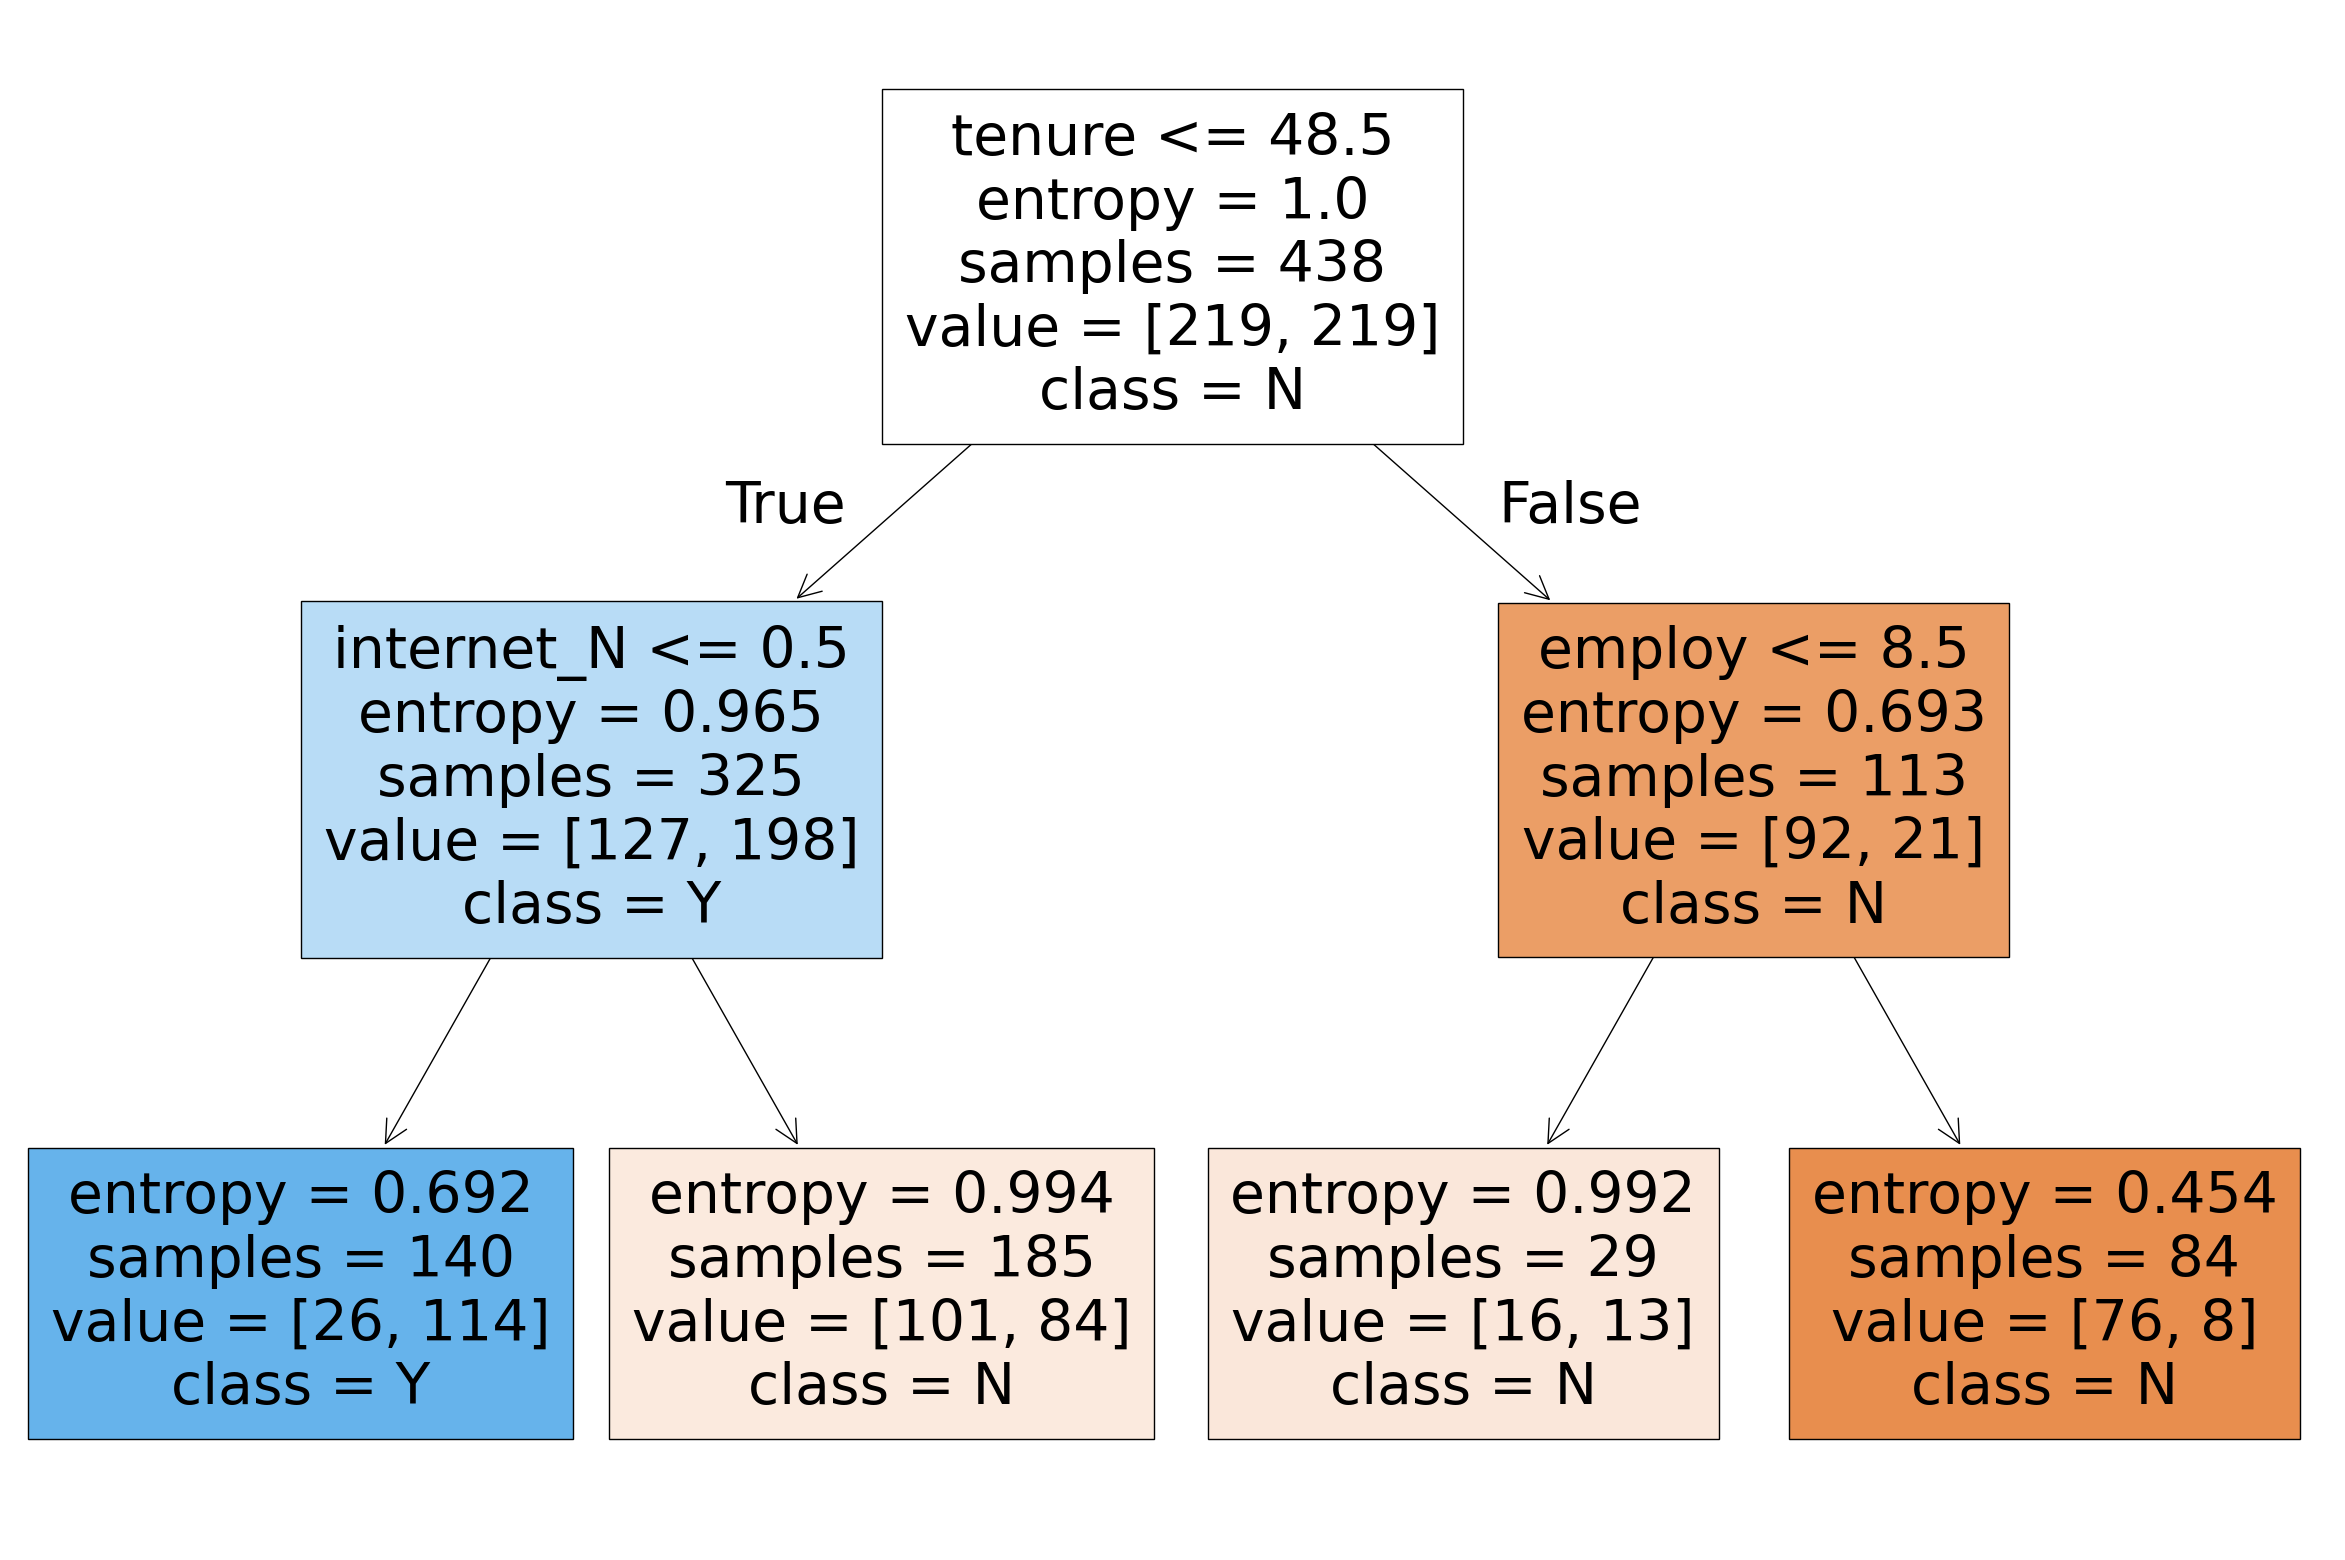

In [45]:
# Plot the tree
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(model,
                   feature_names=list(predictors_train.columns),
                   class_names=['N','Y'],
                   filled=True)

I understand that the first/most important parameter is tenure, which makes sense to me.  Basically the shorter someone is with your company the more likely they will churn ok, no problem.  <br/><br/>Next we have Internet_N, which I am guessing means that the client doesn't have internet service.  I actually think this is more important (since the first one is so obvious).  You could use this as the basis for an ad campaign.  Target new customers who don't yet have the internet and get them to sign up for it (offer a discount or whatever)<br/><br/>The most important thing on the bottom row is the first box, this indicates users who churn and the most reduction in entropy.  This is where we focus.

In [46]:
# Next we will do it with depth of 3
model2  = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = 3)
model2.fit(predictors_train, target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)

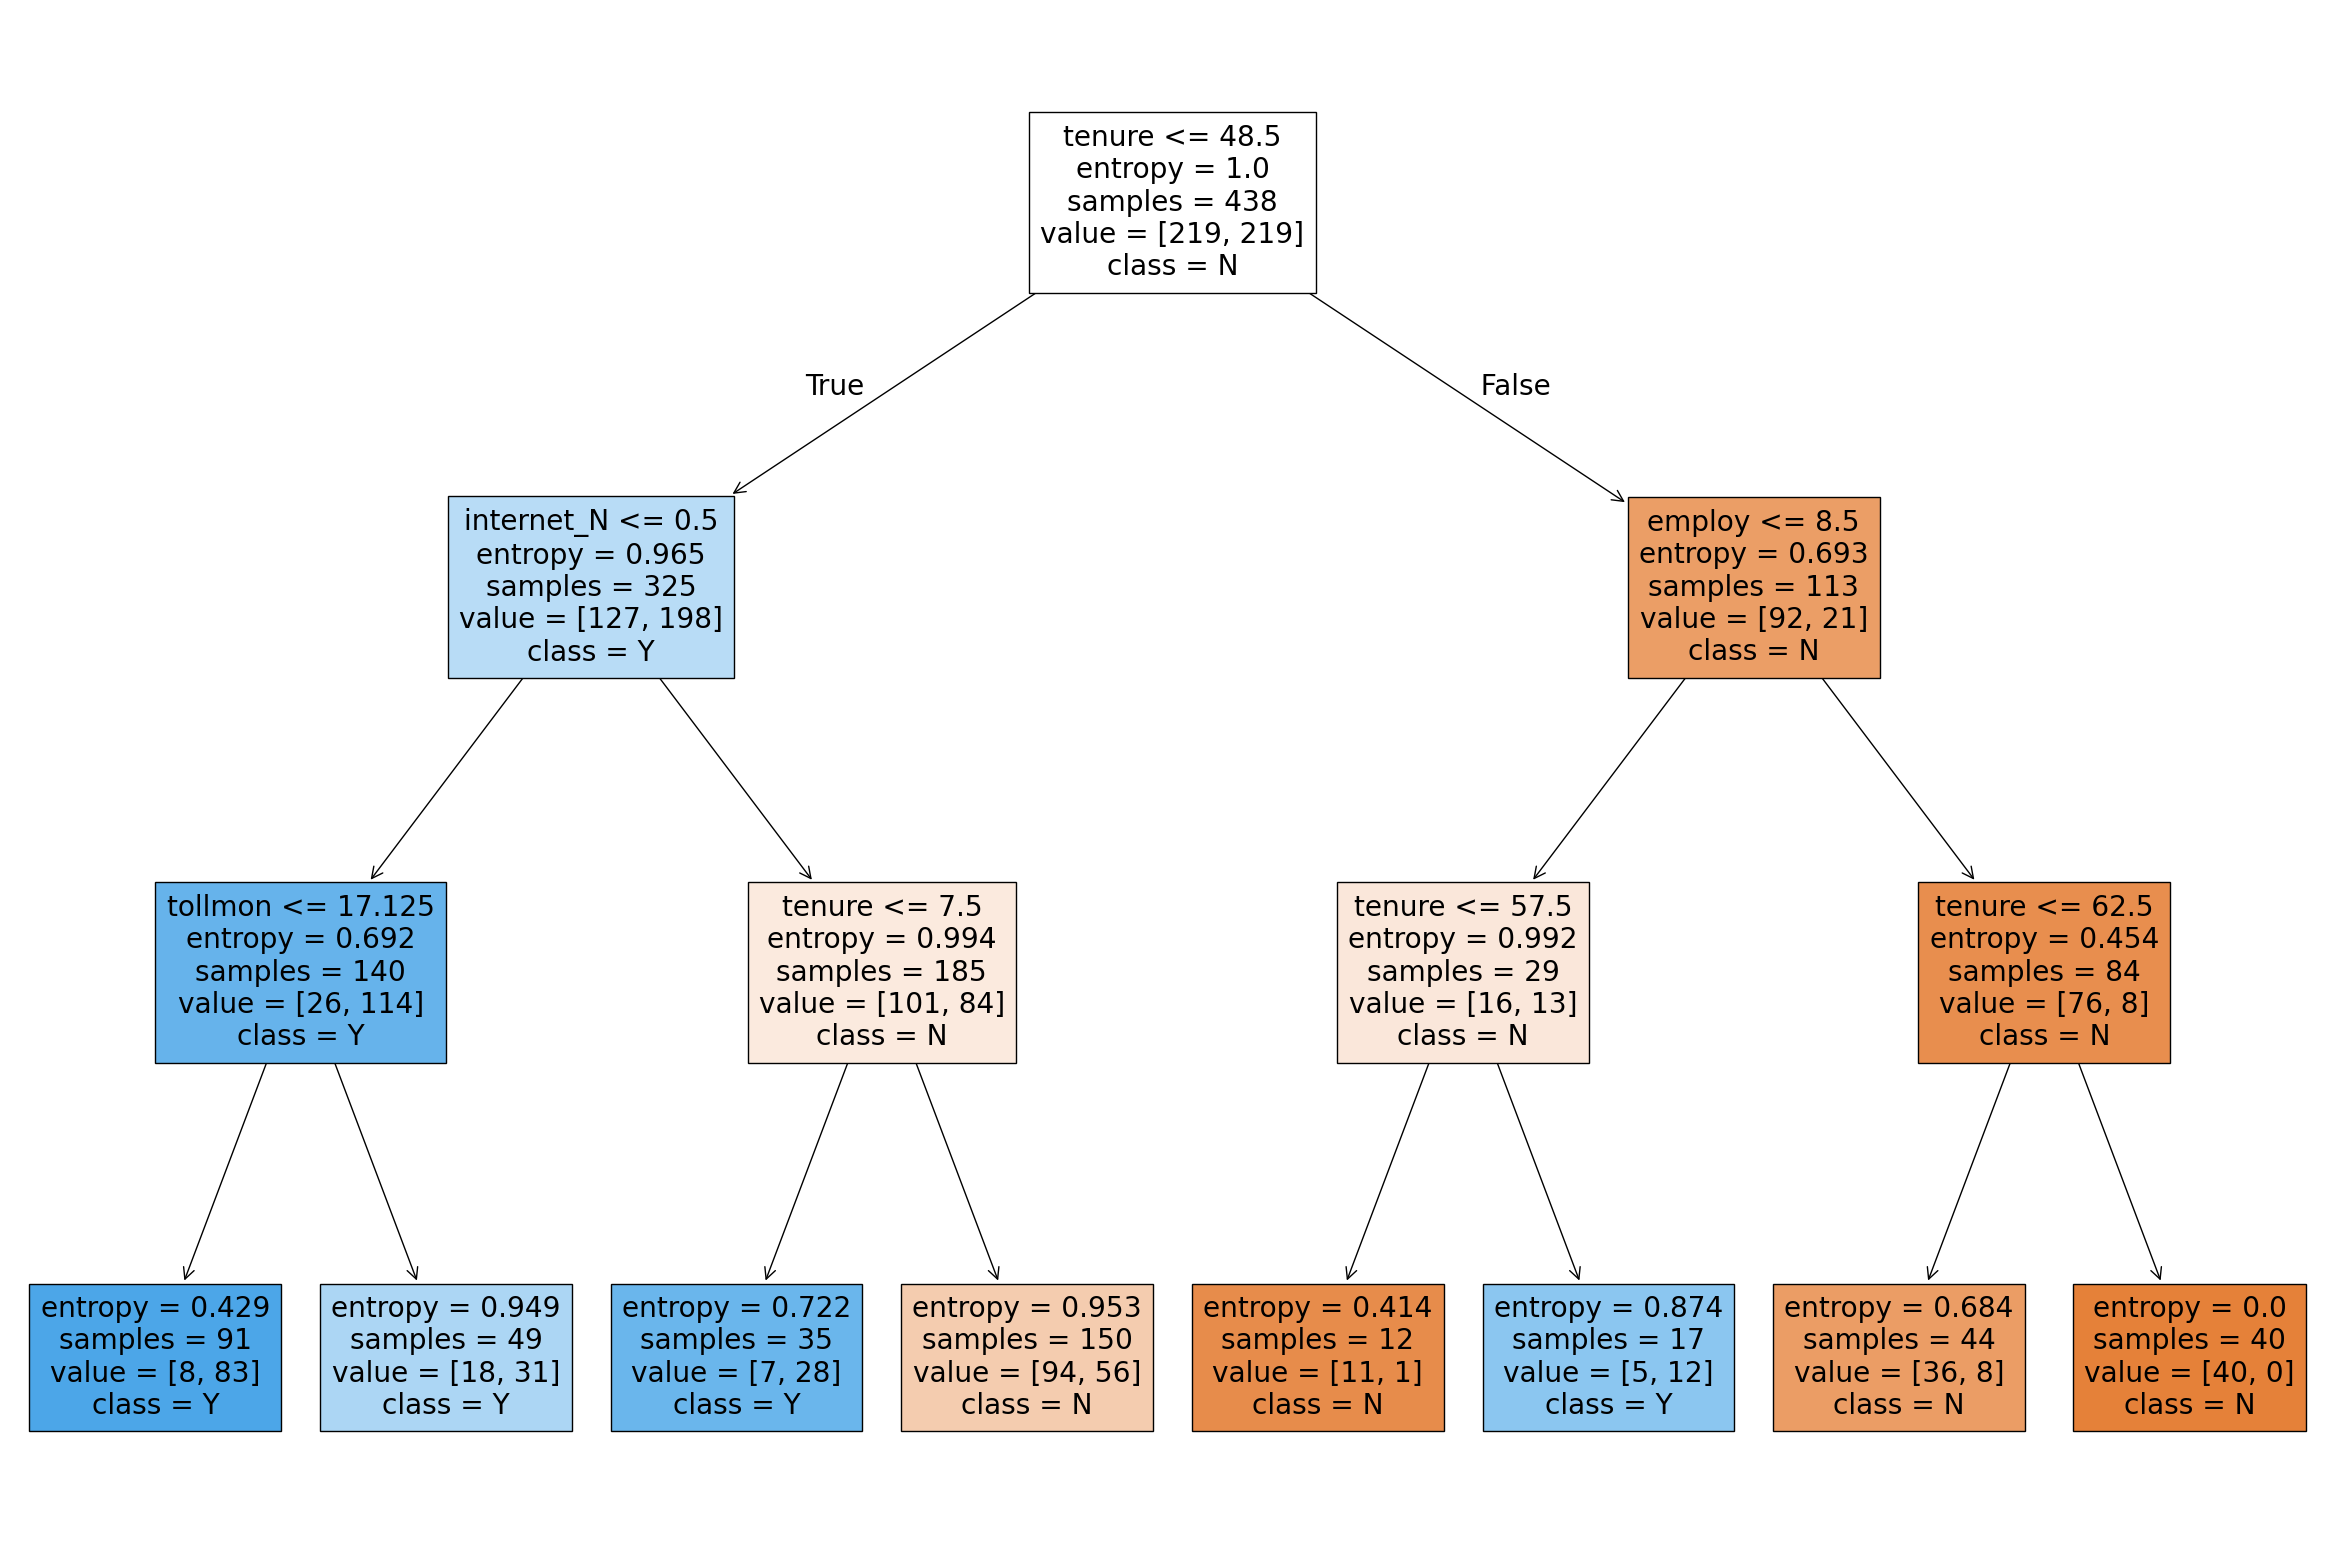

In [47]:
fig2 = plt.figure(figsize=(30,20))
_ = tree.plot_tree(model2,
                   feature_names=list(predictors_train.columns),
                   class_names=['N','Y'],
                   filled=True)

This one gives us more information.  Specifically that tollmon (which we have guessed references the amount of tollfree minutes used in the last month).  While this is interesting, I can't off the top of my head figure out how this is helpful.  I suppose we could encourage more toll free minute usage, but that just doesn't seem like something that would tie someone to the companies product (at least not compared to internet usage).  The thing with internet usage is that it kinda necessitates having some device for which to use the internet.<br/><br/>
Perhaps if we encourage internet usage, people might actually purchase computers and then become more dependent on the company's product.  I don't see a similar path to dependency with toll free minute usage, which is why I suspect this level of information is not useful

In [49]:
from sklearn.metrics import classification_report

# performance metrics/accuracy with model #1 (the two layer model)
prediction_on_test = model.predict(predictors_test)
print(classification_report(target_test, prediction_on_test))

              precision    recall  f1-score   support

           N       0.90      0.81      0.85       161
           Y       0.44      0.62      0.51        39

    accuracy                           0.77       200
   macro avg       0.67      0.71      0.68       200
weighted avg       0.81      0.77      0.78       200



In [50]:
# performance metrics/accuracy with model #2 (three layer model)
prediction_on_test2 = model2.predict(predictors_test)
print(classification_report(target_test, prediction_on_test2))

              precision    recall  f1-score   support

           N       0.93      0.72      0.81       161
           Y       0.40      0.77      0.53        39

    accuracy                           0.73       200
   macro avg       0.66      0.74      0.67       200
weighted avg       0.83      0.73      0.76       200



As you can see the accuracy, recall, f1-score etc.. are different on the two different models.  The second model shows a higher f1-score for the yes segment of data, which technically means it's more accurate at predicting the thing we care about.  However, as stated before, I am not confident that this accuracy actually matters because it's debatable whether or not we can actually do something with that extra data point.<br/><br/>For the heck of it (and because the instructions said to do it), here are the related confusion matrixes

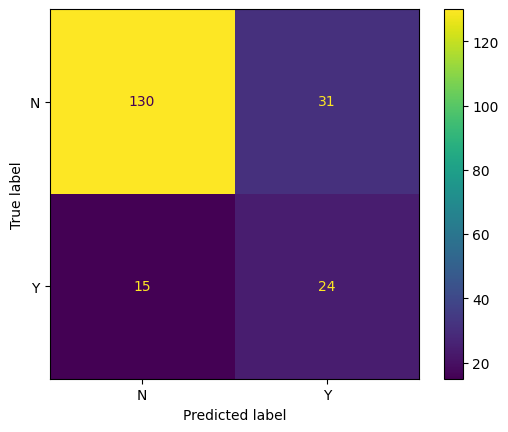

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(target_test, prediction_on_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

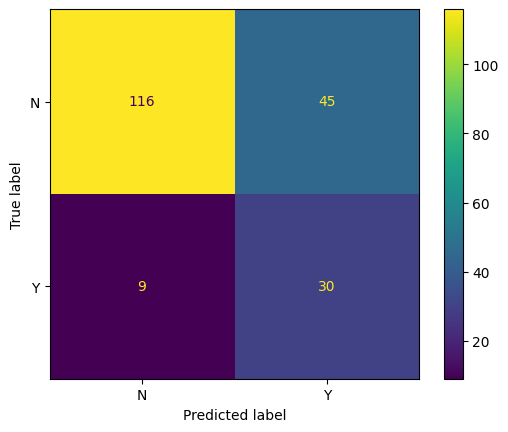

In [53]:
cm2 = confusion_matrix(target_test, prediction_on_test2)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model2.classes_).plot()

This again confirms what I already said when analysing the classification_report results

## Evaluation

While the top model is in fact the three level model.  I do not know how this model is any more practical for business than the two level model.<br/><br/>
At the end of the day, it matters less whether we can accurately predict something than whether there are actions we can take to make use of those predictions.<br/><br/>
In this case, I only see realistic actions taken from the two level model<br/><br/>
This said, I see another aspect.  If this study has in fact proven that various levels of prediction accuracy have not-correlated levels of action in the real world. I would wonder what possible actions could be made regarding levels beyond level 3?  Possibly level 4 or 5 have some useful information that could be acted on.  If this was a real business task, I would dig deeper into this aspect.

In [54]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/ISO470_Assignment01.ipynb" --to html --output "/content/drive/MyDrive/Output/IS470_Assignment01.html"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ISO470_Assignment01.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1460562 bytes to /content/drive/MyDrive/Output/IS470_Assignment01.html
